## Baseline Model:

Now let us build a baseline model on this dataset. Before we start building models, let us look at the variable names which are there in train dataset and not in test dataset.

In [45]:
import pandas as pd
PATH = '/mnt/c/Users/ssant/googledrive/github/google_revenue_predict/data/processed'
train = pd.read_csv(PATH+"/train_flat.csv", dtype={'fullVisitorId':str}, low_memory=False)
test = pd.read_csv(PATH+"/test_flat.csv", dtype={'fullVisitorId':str}, low_memory=False)

train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [46]:
print("Features present only in train set:\n", set(train.columns).difference(set(test.columns)))

Features present only in train set:
 {'trafficSource.campaignCode', 'totals.transactionRevenue'}


<div><div class="alert alert-block alert-info">
> # Pre-processig:

>drop colums

> date

>categorical columns

In [47]:
#Droping columns - only 1 unique value
cols_to_drop = ['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.bounces',
 'totals.newVisits',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.isTrueDirect',
 'sessionId']

train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test = test.drop(cols_to_drop, axis=1)

In [48]:
import datetime

# parsing date
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

Now let us create training and validation splits based on time to build the model. We can take the last two months as validation sample.

In [49]:
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import numpy as np

In [50]:
# Impute 0 for missing target values
train["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals.transactionRevenue"].values
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values

# label encode the categorical variables 
cat_cols = ["channelGrouping", "device.browser", "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", "trafficSource.referralPath", "trafficSource.source"]
num_cols = ["totals.hits", "totals.pageviews"]
for col in cat_cols:
    #print(col)
    lbl = preprocessing.LabelEncoder() 
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str'))) # find unique classes
    train[col] = lbl.transform(list(train[col].values.astype('str'))) # assign numbers 
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [51]:
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

# Split the train dataset into development and validation based on time 
dev_df = train[train['date']<=datetime.date(2017,5,31)] #85%
val_df = train[train['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols]
val_X = val_df[cat_cols + num_cols]
test_X = test[cat_cols + num_cols]


### Model building and training

**Light GBM** is a framework that uses tree based learning algorithm.
- grows tree vertically, leaf-wise. While other algorithm grows level-wise/horizontally.
- When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.
- can handle the large size of data and takes lower memory to run. 
- focuses on accuracy of results, supports GPU learning 
- can easily overfit small data (less 10,000 rows)
- parameter tuning is complicated, covers more than 100 parameters 


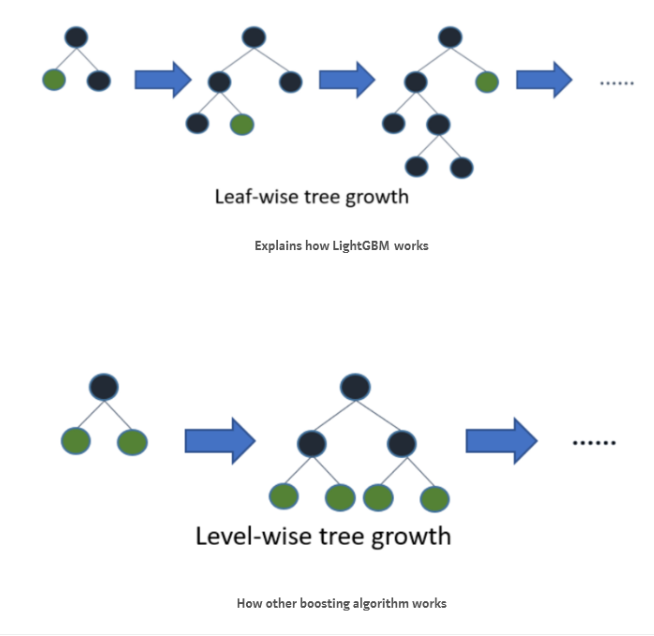

Parameters:

bagging_fraction: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.

feature_fraction: Used when your boosting is random forest. 0.5 feature fraction means LightGBM will select 50% of parameters randomly in each iteration for building trees.

learning_rate: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

num_leaves: number of leaves in full tree, default: 31

In [61]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7, 
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    # convert our training data into LightGBM dataset format:
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75059
[200]	valid_0's rmse: 1.74956
Early stopping, best iteration is:
[136]	valid_0's rmse: 1.74878


Standard deviation is around 1.75, then the model is with e^1.75 or 5 times bigger or smaller of the actula measurement 68% of the time.

In [62]:
pred_test

array([-0.00337357, -0.00337357,  0.00266757, ...,  0.38764264,
       -1.20929899, -1.46349634])


There are some negative values in the predictions. So let us make them 0. Also let us sum up the prediction of multiple instances of a vistor to get one value per visitor. Finally let us take log value of these predictions.

In [57]:
# submission file for kaggle
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [58]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.189626
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.009821


In [63]:
import matplotlib.pyplot as plt
%matplotlib inline



This model with a valid score of 1.74 gets a score of 1.78 in Public LB. Overfitting and bad score.

Feature Importance:
Now let us have a look at the important features of the light gbm model.

Text(0.5,1,'LightGBM - Feature Importance')

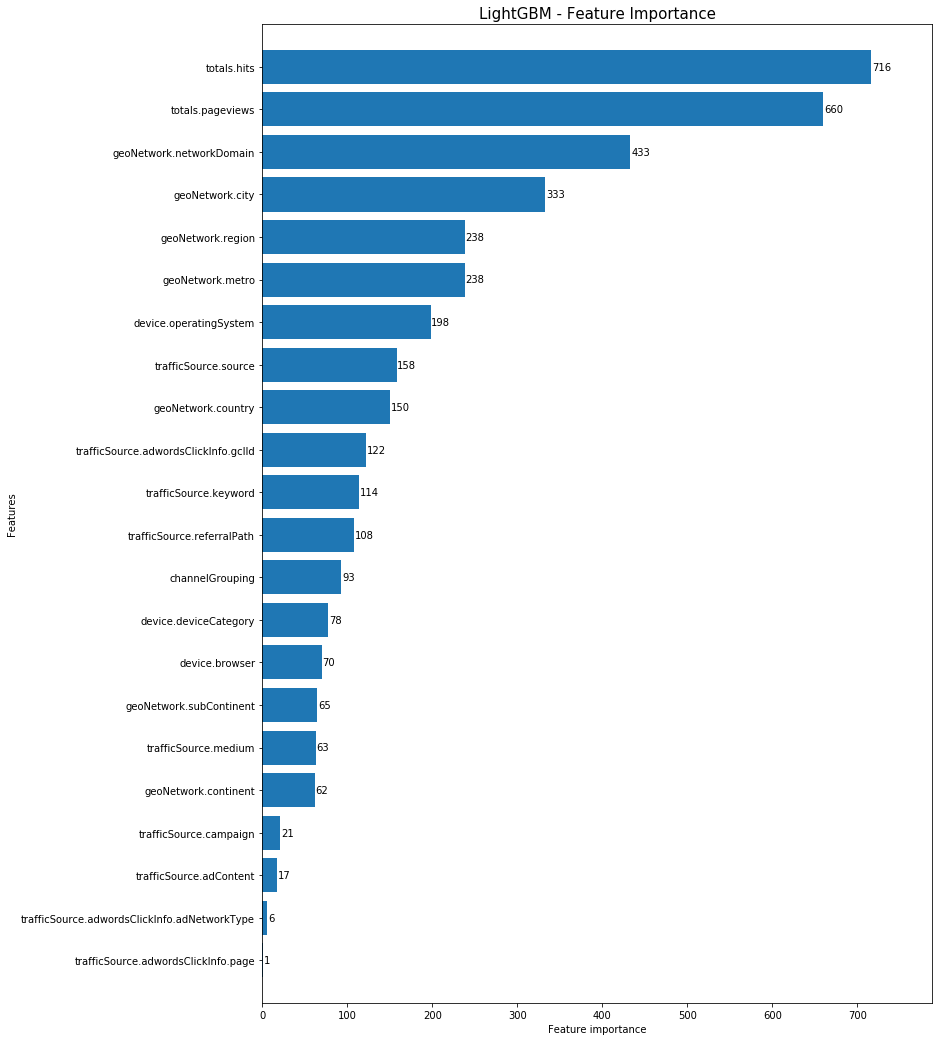

In [64]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)



"totals.hits" turn out to be the most important feature followed by "totals.vies". Network domain and city are next in line.

##### Parameter tunning - [try](<https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc>):

For Faster Speed:

- Use bagging by setting bagging_fraction and bagging_freq
- Use feature sub-sampling by setting feature_fraction
- Use small max_bin
- Use parallel learning

For better results:
 
- Use large max_bin (may be slower)
- Use small learning_rate with large num_iterations
- Use large num_leaves(may cause over-fitting)
- Try dart
- Try to use categorical feature directly

To deal with over-fitting:

- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction
- Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
- Try max_depth to avoid growing deep tree